### Packages and Libraries

In [2]:

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd

from hypso import Hypso1

from rasterio.transform import Affine
import rasterio

import pyproj
from matplotlib.colors import ListedColormap, BoundaryNorm

import os

from hypso.classification import decode_jon_cnn_water_mask, decode_jon_cnn_land_mask, decode_jon_cnn_cloud_mask




### Paths

In [1]:
# Files loaded from NIBIO's SR16 raster

sr16_tif_paths = [
    # '/home/salyken/PRISMA/TreeMap/Akershus/sr16_32_SRRTRESLAG.tif',
    # '/home/salyken/PRISMA/TreeMap/Buskerud/sr16_33_SRRTRESLAG.tif',
    # '/home/salyken/PRISMA/TreeMap/Innlandet/sr16_34_SRRTRESLAG.tif',
    # '/home/salyken/PRISMA/TreeMap/Oslo/sr16_3_SRRTRESLAG.tif',
    # '/home/salyken/PRISMA/TreeMap/østfold/sr16_31_SRRTRESLAG.tif',
    # '/home/salyken/PRISMA/TreeMap/Rogaland/sr16_11_SRRTRESLAG.tif',
    '/home/salyken/PRISMA/TreeMap/Trøndelag/sr16_50_SRRTRESLAG.tif',
    '/home/salyken/PRISMA/TreeMap/Nordland/sr16_18_SRRTRESLAG.tif',
    '/home/salyken/PRISMA/TreeMap/MøreogRomsdal/sr16_15_SRRTRESLAG.tif',
    # '/home/salyken/PRISMA/TreeMap/Vestfold/sr16_39_SRRTRESLAG.tif',
    # '/home/salyken/PRISMA/TreeMap/Vestlandet/sr16_46_SRRTRESLAG.tif',
    # '/home/salyken/PRISMA/TreeMap/Finnmark/sr16_56_SRRTRESLAG.tif'
]

sr16_tif_path = '/home/salyken/PRISMA/TreeMap/Akershus/sr16_32_SRRTRESLAG.tif'


In [ ]:

dir_path = '/home/salyken/PRISMA/HYPSO_data/ingdalen/ingdalen_2024-05-04T11-01-34Z'

scene_name = 'ingdalen_2024-05-04T11-01-34Z'

# HYPSO-1 Capture
h1_l1a_nc_file = os.path.join(dir_path, 'ingdalen_2024-05-04T11-01-34Z-l1a.nc')
# h1_points_file = os.path.join(dir_path, 'sift-bin.points')
h1_points_file = os.path.join(dir_path, 'gcp.points')
h1_lats_file = os.path.join(dir_path, 'latitudes_indirectgeoref.dat')
h1_lons_file = os.path.join(dir_path, 'longitudes_indirectgeoref.dat')

labels_file = os.path.join(dir_path, 'jon-cnn.labels')


satobj_h1 = Hypso1(path=h1_l1a_nc_file, verbose=True)

[INFO] Loading L1a capture ingdalen_2024-05-04T11-01-34Z
[INFO] Capture spatial dimensions: (598, 1092)
[INFO] Capture capture type: wide


In [6]:
with rasterio.open(sr16_tif_path) as src:
    print("CRS:", src.crs)
    print("Bounds:", src.bounds)
    print("Width, Height:", src.width, src.height)
    print("Transform:", src.transform)
    print("Driver:", src.driver)
    print("Count of bands:", src.count)

CRS: EPSG:25833
Bounds: BoundingBox(left=235184.0, bottom=6599440.0, right=328160.0, top=6724976.0)
Width, Height: 5811 7846
Transform: | 16.00, 0.00, 235184.00|
| 0.00,-16.00, 6724976.00|
| 0.00, 0.00, 1.00|
Driver: GTiff
Count of bands: 1


### Calibrate datacube and generate top-of-atmosphere (TOA) reflectance:

In [7]:
satobj_h1.generate_l1b_cube() # TOA radiance
satobj_h1.generate_l1c_cube() # TOA radiance + direct georeferencing
satobj_h1.generate_l1d_cube() # TOA reflectance

[INFO] Running calibration routines...
[INFO] Running radiometric calibration...


[INFO] Running smile correction...
[INFO] Running destriping correction...
[INFO] Running spectral correction...
[INFO] Running direct georeferencing...
[INFO] ADCS samples: 430
[INFO] ADCS time range: 1714819800.000000 to 1714820760.000000
[INFO] Frame time range: 1714820494.047503 to 1714820543.797503
[INFO] 199 sample(s) inside frame time range
[INFO] Interpolating 598 frames
[INFO] Computing pixel latitude and longitude coordinates ...
[INFO] Interpolating pixel coordinate gaps...
[INFO] Direct georeferencing done
[INFO] Running track geometry computations...
[INFO] Using UTM map: WGS 84 / UTM zone 32N EPSG: 32632
[INFO] Track geometry computations done.
[INFO] Running angles geometry computations...
[INFO] Computing local angles (sun and satellite azimuth and zenith angles) ...
[INFO] Using astropy on a subsampling of pixels ... (TODO skyfield may be faster)
[INFO] Interpolating the rest of the pixels ...
[INFO] Computing local angles done
[INFO] Angles geometry computations done.

### Read lat/lons from 'latitudes_indirectgeoref.dat' and 'longitudes_indirectgeoref.dat' files generating using  coastline matching aglroithm

In [8]:
try:

    # Read from latitudes_indirectgeoref.dat
    with open(h1_lats_file, mode='rb') as file:
        file_content = file.read()
    
    lats = np.frombuffer(file_content, dtype=np.float32)

    lats = lats.reshape(satobj_h1.spatial_dimensions)

    # Read from longitudes_indirectgeoref.dat
    with open(h1_lons_file, mode='rb') as file:
        file_content = file.read()
    
    lons = np.frombuffer(file_content, dtype=np.float32)

    lons = lons.reshape(satobj_h1.spatial_dimensions)

    # Directly provide the indirect lat/lons loaded from the file. This function will run the track geometry computations.
    satobj_h1.run_indirect_georeferencing(latitudes=lats, longitudes=lons)


except Exception as ex:
    print(ex)
    print('Indirect georeferencing has failed. Defaulting to indirect georeferencing using points file.')

    #satobj.run_direct_georeferencing()

    #lats = satobj.latitudes
    #lons = satobj.longitudes

    satobj_h1.run_indirect_georeferencing(points_file_path=h1_points_file, flip=False)

[Errno 2] No such file or directory: '/home/salyken/PRISMA/HYPSO_data/ingdalen/ingdalen_2024-05-04T11-01-34Z/latitudes_indirectgeoref.dat'
Indirect georeferencing has failed. Defaulting to indirect georeferencing using points file.
[INFO] Running indirect georeferencing...
[INFO] No image mode provided. Detected image mode: bin3
[INFO] Does check_star_tracker_orientation() indicate image flip?
False
[INFO] Running track geometry computations...
[INFO] Using UTM map: WGS 84 / UTM zone 32N EPSG: 32632
[INFO] Track geometry computations done.
[INFO] Running angles geometry computations...
[INFO] Computing local angles (sun and satellite azimuth and zenith angles) ...
[INFO] Using astropy on a subsampling of pixels ... (TODO skyfield may be faster)
[INFO] Interpolating the rest of the pixels ...
[INFO] Computing local angles done
[INFO] Angles geometry computations done.


### Load the sea-land-cloud masks (SLC) from the jon-cnn-labels file. Theses masks are created from the onboard classification so they aren't 100% accurate:

In [9]:
water_mask = decode_jon_cnn_water_mask(file_path=labels_file, spatial_dimensions=satobj_h1.spatial_dimensions)
cloud_mask = decode_jon_cnn_cloud_mask(file_path=labels_file, spatial_dimensions=satobj_h1.spatial_dimensions)

satobj_h1.land_mask = water_mask # using land_mask attribute as water_mask
satobj_h1.cloud_mask = cloud_mask




### Custom Masks

In [39]:
l1d_cube = satobj_h1.l1d_cube

MASKS_HYPSO = {
    'wat_band1': 10,       # adjust as needed
    'wat_band2': 70,
    'wat_b1_max': 0.4,    # assuming normalized reflectance (0–1)
    'wat_rat_max': 0.4,
    'clsn_band': 90,
    'clsn_min': 0.14     # again assuming reflectance
}

cube_np = l1d_cube.values

band1 = cube_np[:, :, MASKS_HYPSO['wat_band1']]
band2 = cube_np[:, :, MASKS_HYPSO['wat_band2']]
cloud_band = cube_np[:, :, MASKS_HYPSO['clsn_band']]


cloud_mask_1 = (
    (cloud_band > MASKS_HYPSO['clsn_min']) &
    ~np.isnan(cloud_band)
)



### Final Mask

In [11]:
land_mask = ~(cloud_mask_1 | water_mask)

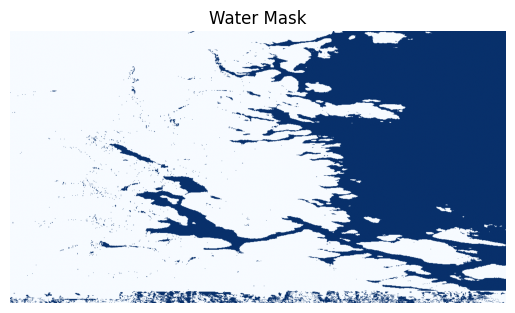

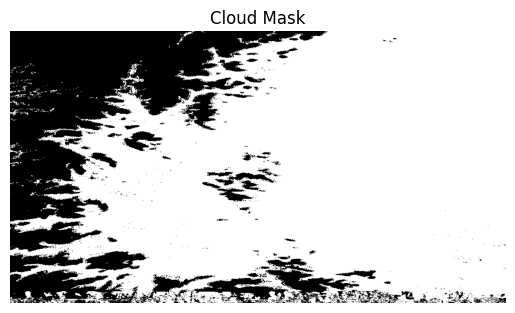

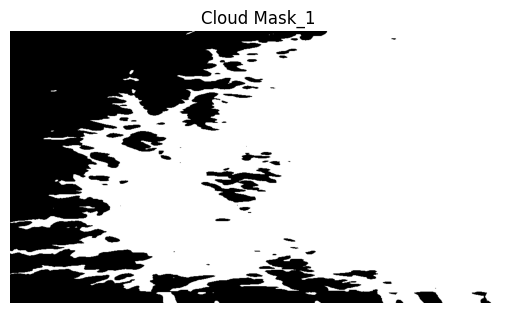

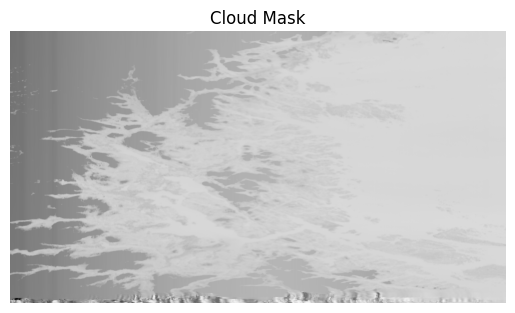

In [40]:
plt.imshow(water_mask, cmap="Blues")
plt.title("Water Mask")
plt.axis("off")
plt.show()

plt.imshow(cloud_mask, cmap="Greys")
plt.title("Cloud Mask")
plt.axis("off")
plt.show()


plt.imshow(cloud_mask_1, cmap="Greys")
plt.title("Cloud Mask_1")
plt.axis("off")
plt.show()

plt.imshow(l1d_cube[:,:,45], cmap="Greys")
plt.title("Cloud Mask")
plt.axis("off")
plt.show()

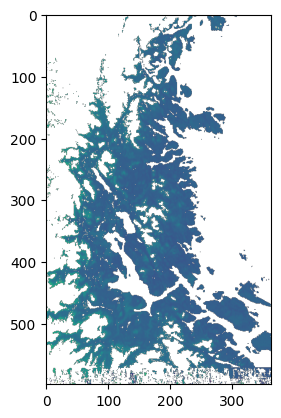

In [13]:
plt.imshow(satobj_h1.masked_l1d_cube[:,::3,40])

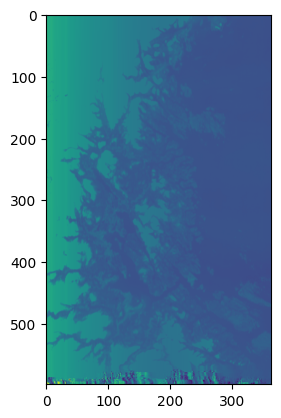

In [14]:
plt.imshow(satobj_h1.l1d_cube[:,::3,40])

### Keep the HYPSO data as-is and resample the SR16 data to the HYPSO swath 

In [15]:
from hypso.geometry_definition import generate_hypso_swath_def

swath_def = generate_hypso_swath_def(satobj_h1, use_indirect_georef=True)

In [16]:
swath_lats = satobj_h1.latitudes_indirect
swath_lons = satobj_h1.longitudes_indirect

In [17]:

# Build coordinate transformer (WGS84 → ETRS89 / UTM Zone 33N)
transformer = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:25833", always_xy=True)

# Flatten lat/lon grids
lon_flat = swath_lons.flatten()
lat_flat = swath_lats.flatten()

# Transform coordinates
x_utm, y_utm = transformer.transform(lon_flat, lat_flat)

# Stack into (N, 2) array
coords = list(zip(x_utm, y_utm))

In [18]:
# Initialize final_labels
final_labels = None

# Loop over all SR16 maps
for i, tif_path in enumerate(sr16_tif_paths):
    print(f"Sampling from {tif_path}...")

    with rasterio.open(tif_path) as src:
        sampled_values = list(src.sample(coords, indexes=1))
        sampled_array = np.array(sampled_values).reshape(swath_lats.shape)

    # Set -9999 or other nodata to 0
    sampled_array[sampled_array == -9999] = 0

    if final_labels is None:
        # First SR16 map → initialize
        final_labels = sampled_array
    else:
        # Later SR16 maps → overwrite where new labels are valid
        mask_valid = sampled_array > 0
        final_labels[mask_valid] = sampled_array[mask_valid]

print("Finished combining all SR16 maps!")

Sampling from /home/salyken/PRISMA/TreeMap/Trøndelag/sr16_50_SRRTRESLAG.tif...
Sampling from /home/salyken/PRISMA/TreeMap/Nordland/sr16_18_SRRTRESLAG.tif...
Sampling from /home/salyken/PRISMA/TreeMap/MøreogRomsdal/sr16_15_SRRTRESLAG.tif...
Finished combining all SR16 maps!


In [19]:
# final_labels = sr16_labels.copy()

# # Where sr16_labels_2 has valid (non-0) labels, overwrite final_labels
# mask_valid_2 = sr16_labels_2 > 0
# final_labels[mask_valid_2] = sr16_labels_2[mask_valid_2]

sr16_labels = final_labels

In [20]:
# np.unique(sr16_sampled)

In [21]:
masked_sr16_labels = np.where(land_mask, sr16_labels, np.nan)

In [22]:
masked_sr16_labels.shape

(598, 1092)

In [23]:
print(np.unique(masked_sr16_labels))

[ 0.  1.  2.  3. nan]


In [24]:
np.save("masked_sr16_labels.npy", masked_sr16_labels)

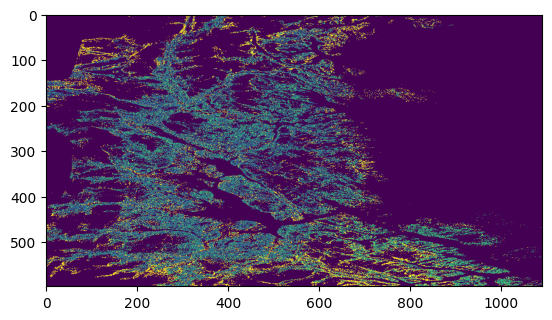

In [25]:
plt.imshow(sr16_labels)

In [26]:
# GRAN/SPRUCE = 1, FURU/PINE = 2, LAUV/DECIDIOUS = 3

In [27]:
l1d_cube.shape
print(598*1092)
print(np.unique(sr16_labels))
sr16_forest_labels = sr16_labels == 1,2,3
sr16_labels.shape


653016
[0 1 2 3]


(598, 1092)

In [28]:
print(np.unique(masked_sr16_labels))

[ 0.  1.  2.  3. nan]


### Plot Masks

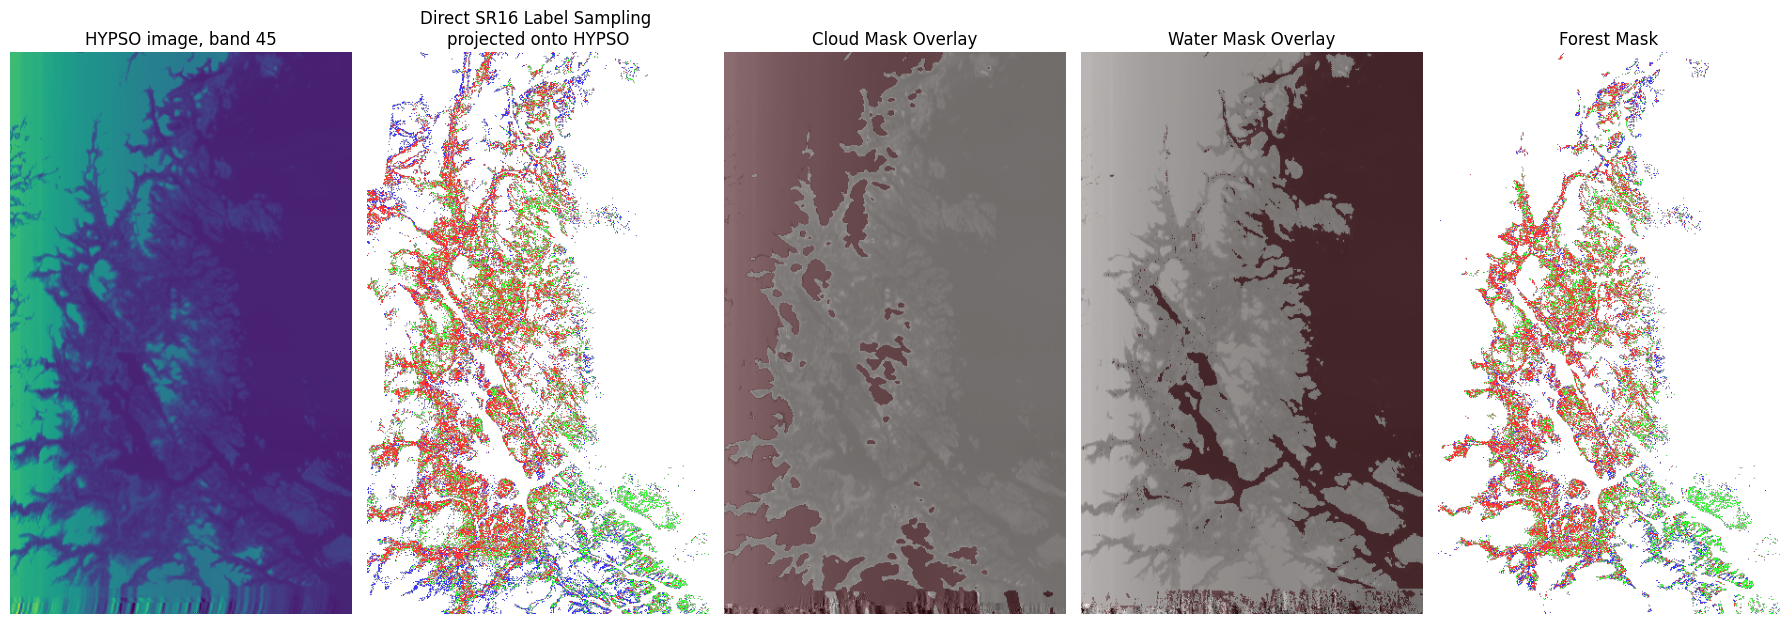

In [30]:
colors = [
    (0.0, 0.0, 0.0, 0.0),  # 0: transparent background
    (1.0, 0.0, 0.0, 0.8),  # 1: red - spruce / gran
    (0.0, 1.0, 0.0, 0.8),  # 2: green - pine / furu
    (0.0, 0.0, 1.0, 0.8)   # 3: blue - deciduous / lauv
]
cmap = ListedColormap(colors)
norm = BoundaryNorm([0, 1, 2, 3, 4], cmap.N)

fig, axs = plt.subplots(1, 5, figsize=(18, 8))

# 1. SR16 label overlay
axs[0].imshow(l1d_cube[:,::3,69])
axs[0].set_title("HYPSO image, band 45")
axs[0].axis("off")

axs[1].imshow(sr16_labels[:,::3], cmap=cmap, alpha=1)
axs[1].set_title("Direct SR16 Label Sampling \nprojected onto HYPSO")
axs[1].axis("off")

# 2. Cloud mask overlay
axs[2].imshow(satobj_h1.l1d_cube[:,::3,45], cmap="gray")
axs[2].imshow(cloud_mask_1[:,::3], cmap="Reds", alpha=0.3)
axs[2].set_title("Cloud Mask Overlay")
axs[2].axis("off")

axs[3].imshow(satobj_h1.l1d_cube[:,::3,45], cmap="gray")
axs[3].imshow(water_mask[:,::3], cmap="Reds", alpha=0.3)
axs[3].set_title("Water Mask Overlay")
axs[3].axis("off")


# 3. Forest labels (with embedded text legend)
axs[4].imshow(masked_sr16_labels[:,::3], cmap=cmap, norm=norm)
axs[4].set_title("Forest Mask")
axs[4].axis("off")

# Add text legend manually (in image)
# axs[2].text(10, 20, "1: Spruce", color="red", fontsize=12, backgroundcolor="white")
# axs[2].text(10, 45, "2: Pine", color="green", fontsize=12, backgroundcolor="white")
# axs[2].text(10, 70, "3: Deciduous", color="blue", fontsize=12, backgroundcolor="white")

plt.tight_layout()
plt.show()

plt.close()


In [ ]:
unique_labels = np.unique(sr16_labels)
print("Unique labels in sr16_labels:", unique_labels)

print("Unique in water_mask:", np.unique(water_mask))
print("Unique in cloud_mask:", np.unique(cloud_mask_1))

Unique labels in sr16_labels: [0 1 2 3]
Unique in water_mask: [False  True]
Unique in cloud_mask: [False  True]


### Plot Mask in Faubai Colors

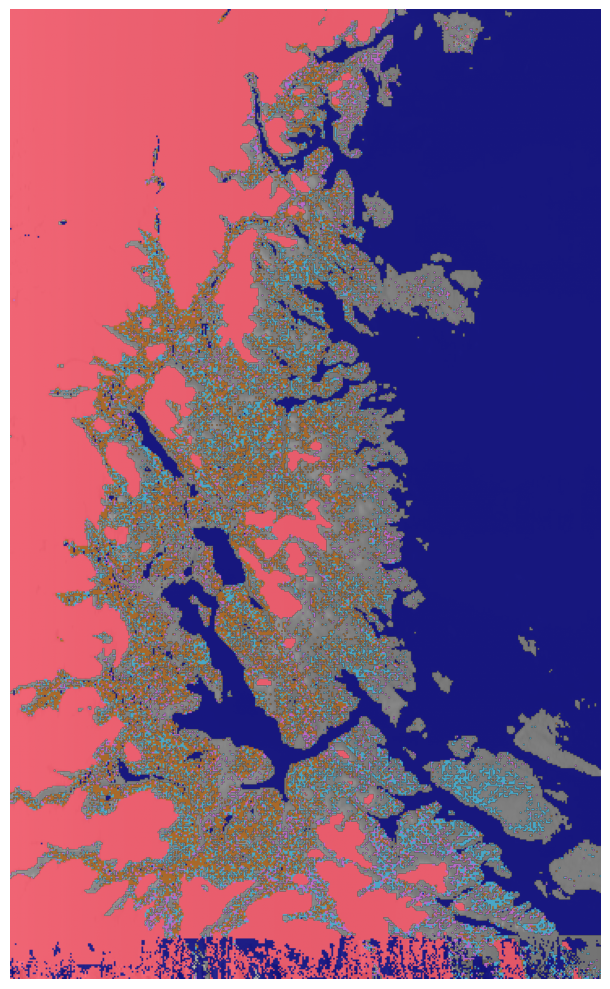

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# Define the combined color map (transparent + spruce + pine + deciduous + water + cloudsnow)
colors = [
    (0.0, 0.0, 0.0, 0.0),        # 0: transparent
    (180/255, 100/255, 20/255, 0.8),  # 1: spruce - brown-orange
    (60/255, 180/255, 220/255, 0.8),  # 2: pine - cyan
    (200/255, 100/255, 220/255, 0.8), # 3: deciduous - light purple
    (0/255, 0/255, 130/255, 0.8),     # 4: water - dark blue
    (255/255, 80/255, 100/255, 0.8)   # 5: cloud/snow - bright red
]
cmap = ListedColormap(colors)
norm = BoundaryNorm([0, 1, 2, 3, 4, 5, 6], cmap.N)

# ----- Create the combined label map -----
# Assume you have these masks separately:
# sr16_labels: 1 (spruce), 2 (pine), 3 (deciduous)
# water_mask: binary mask (True = water)
# cloud_mask_1: binary mask (True = cloudsnow)


# Start with the forest labels
final_labels = masked_sr16_labels.copy()

# Overlay cloud/snow (assign new class 5 where cloud mask is true)
final_labels[cloud_mask_1 == 1] = 5

# Overlay water (assign new class 4 where water mask is true)
final_labels[water_mask == 1] = 4



# ----- Plotting -----
plt.figure(figsize=(10, 10))

# 1. Grayscale HYPSO base image
plt.imshow(satobj_h1.l1d_cube[:,::3,45], cmap="gray", alpha = 0.7)

# 2. Overlay all classes with transparent colors
plt.imshow(final_labels[:,::3], cmap=cmap, norm=norm)

plt.axis("off")

plt.tight_layout()
plt.show()


### Save labels in one main xlsx file, and one csv file for each image, as well as the corresponding cubes

In [ ]:
label_counts = {
    "spruce": np.sum(masked_sr16_labels == 1),
    "pine": np.sum(masked_sr16_labels == 2),
    "deciduous": np.sum(masked_sr16_labels == 3),
    "Water": np.sum(water_mask),
    "cloudsnow": np.sum(cloud_mask_1), 
}

# PRISMA: 0:'other', 1:'spruce', 2:'pine', 3:'deciduous', 4:'water', 5:'cloudsnow'

scene_data = {
    "name": scene_name, 
    "mean_lat": np.nanmean(swath_lats),
    "mean_lon": np.nanmean(swath_lons),
    **label_counts
}

labels_path = "/home/salyken/PRISMA/HYPSO_data/list/hypso_labels.xlsx"


# Load or create Excel
if os.path.exists(labels_path):
    df = pd.read_excel(labels_path)

    # Check if the scene already exists
    if scene_name in df['name'].values:
        print(f" Scene '{scene_name}' already exists in the dataset. Skipping.")
    else:
        # Append new row to the existing DataFrame
        df = pd.concat([df, pd.DataFrame([scene_data])], ignore_index=True)
        df.to_excel(labels_path, index=False)
        print(f" Scene '{scene_name}' added to {labels_path}.")
else:
    # Create new DataFrame and file

    print(f"Can't find Excel file")

In [ ]:
masked_sr16_labels = np.nan_to_num(masked_sr16_labels, nan=0).astype(int)

output_path = f"/home/salyken/PRISMA/HYPSO_data/labels/{scene_name}_labels.csv"
np.savetxt(output_path, masked_sr16_labels, fmt='%d', delimiter=" ")
print(f" Saved label mask to: {output_path}")


In [38]:
np.save(f"/home/salyken/PRISMA/HYPSO_data/cube/{scene_name}_l1d_cube.npy", l1d_cube)